# Delay neuron testing

In [198]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [199]:
%matplotlib inline
import sys
from pathlib import Path
sys.path.append(str(Path('..') / 'src'))

import numpy as np
import matplotlib.pyplot as plt

from config import PhysicsConfig, SpikingRadarConfig, ObjectsConfig
from transmitter import SpikingRadarTx, SpikingRadarTransmitter, SingleSpikeTransmitter
from environment import SpikingRadarChannel_1D
from receiver import SpikingRadarRx, SpikingRadarReceiver_1D
from models.spiking_radar import SpikingRadarCorrelator
from models.spiking_lif_delay import SpikingLIFDelayEstimator
from output import SpikingRadarResult_1D



In [277]:
# Setup and config

physics_config = PhysicsConfig(wave_type="sound")
model_config = SpikingRadarConfig(
    fs_hz=100_000.0,
    duration_s=0.1,
    spike_prob_per_ms=0.1,
    chirp_duration_s=0.005,
    chirp_bandwidth_hz=5_000.0,
    chirp_start_hz=1_000.0,
    carrier_hz=20_000.0,
    attenuation=0.5,
    noise_std=0.1,
    threshold=0.5,
    lowpass_cutoff_hz=20_000.0,
)
objects = ObjectsConfig(object_location_1D = 3.0)


tau_ms = 5/model_config.fs_hz # 5 samples

transmitter = SingleSpikeTransmitter(model_config)
environment = SpikingRadarChannel_1D(model_config, physics_config, objects)
receiver = SpikingRadarReceiver_1D(model_config)
processing_model = SpikingLIFDelayEstimator(
    model_config,
    physics_config,
    max_delay_s=0.1,        # search window
    tau_m_s=tau_ms,          # coincidence window (~5 samples)
    w_tx=1.0,
    w_rx=1.0,
    v_th=1.5,
)






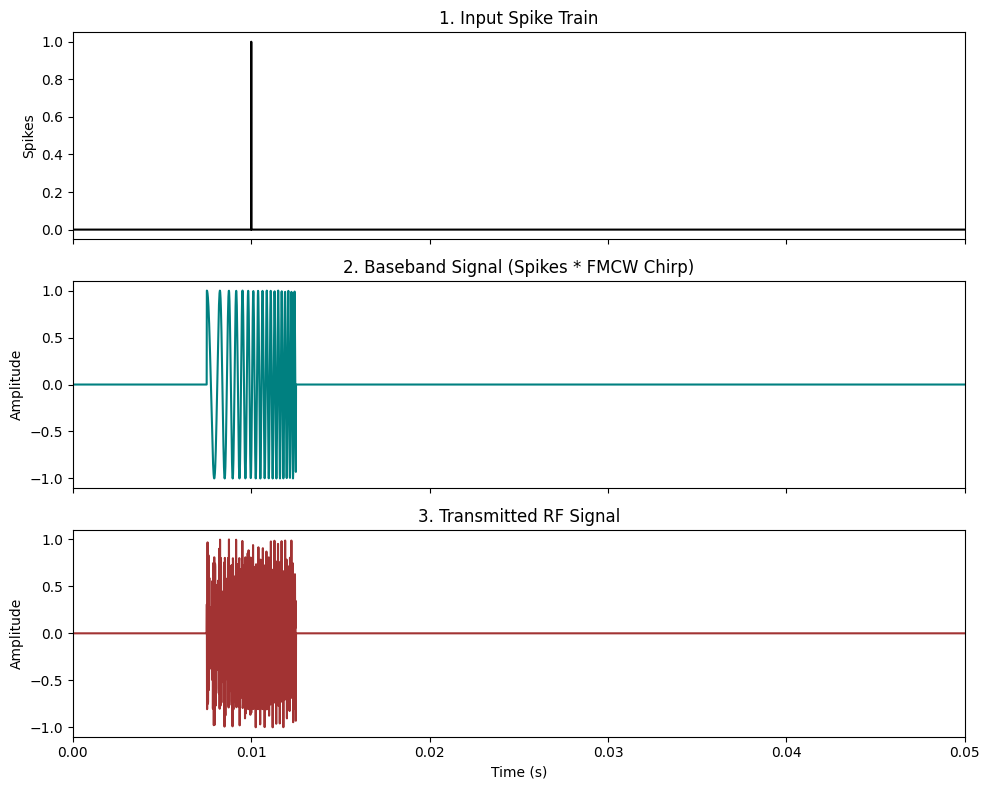

(<Figure size 1000x800 with 3 Axes>,
 array([<Axes: title={'center': '1. Input Spike Train'}, ylabel='Spikes'>,
        <Axes: title={'center': '2. Baseband Signal (Spikes * FMCW Chirp)'}, ylabel='Amplitude'>,
        <Axes: title={'center': '3. Transmitted RF Signal'}, xlabel='Time (s)', ylabel='Amplitude'>],
       dtype=object))

In [278]:
# transmitter

tx = transmitter.build()
transmitter.plot(tx)


In [279]:
# Environment

rx_signal = environment.propagate(tx.tx_signal)

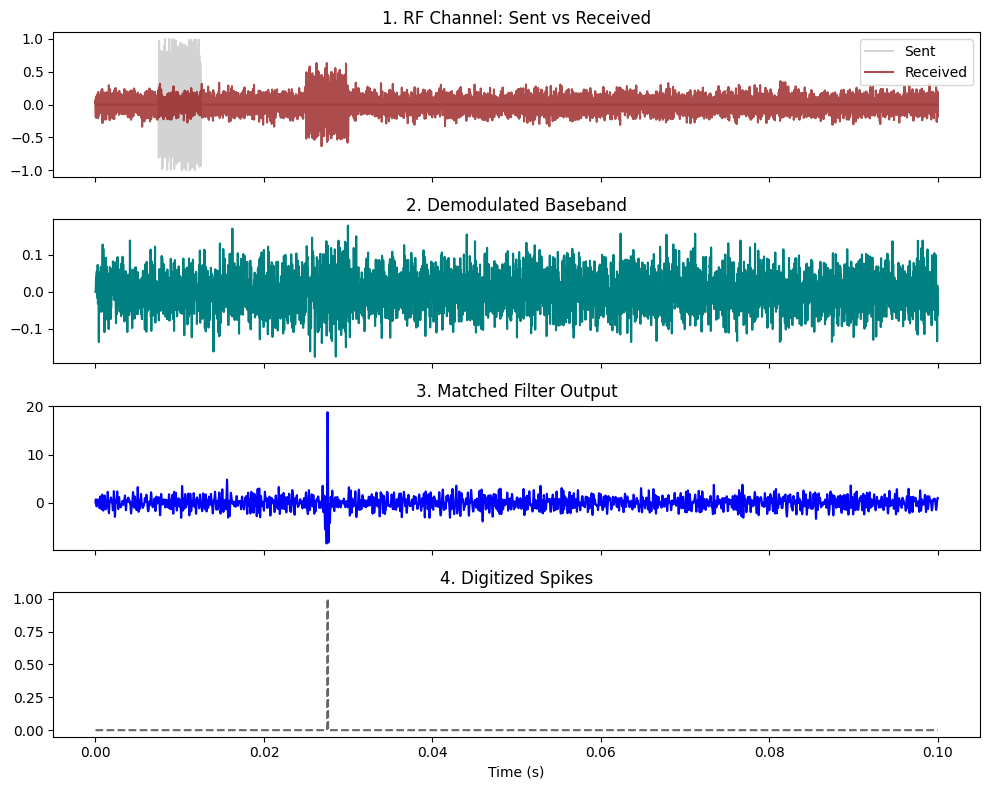

(<Figure size 1000x800 with 4 Axes>,
 array([<Axes: title={'center': '1. RF Channel: Sent vs Received'}>,
        <Axes: title={'center': '2. Demodulated Baseband'}>,
        <Axes: title={'center': '3. Matched Filter Output'}>,
        <Axes: title={'center': '4. Digitized Spikes'}, xlabel='Time (s)'>],
       dtype=object))

In [280]:
# Receiver

demod_raw = receiver.demodulate(rx_signal, tx.time_s)
rx_baseband = receiver.lowpass(demod_raw)
recovered_signal = receiver.matched_filter(rx_baseband, tx.chirp_template)
recovered_spikes = receiver.recover_spikes(recovered_signal)

rx = SpikingRadarRx(
    rx_signal=rx_signal,
    rx_baseband=rx_baseband,
    recovered_signal=recovered_signal,
    recovered_spikes=recovered_spikes,
)
receiver.plot(tx.time_s, tx.tx_signal, rx)

Text(0.5, 1.0, 'Recovered spikes fed to SNN')

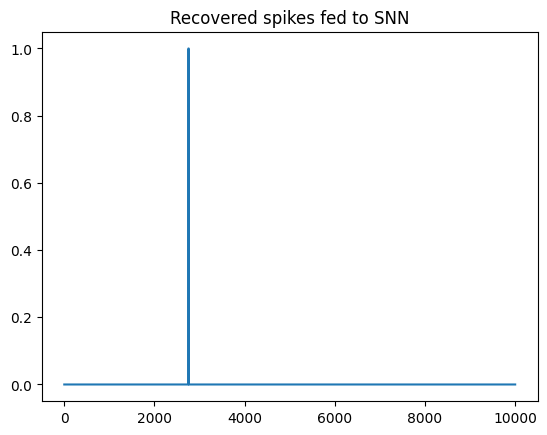

In [281]:
plt.plot(rx.recovered_spikes)
plt.title("Recovered spikes fed to SNN")


LIFDelayResult(delay_samples=1751, delay_s=0.01751, distance_m=3.002965, spike_counts=array([0, 0, 0, ..., 0, 0, 0]), delays_s=array([0.000e+00, 1.000e-05, 2.000e-05, ..., 9.998e-02, 9.999e-02,
       1.000e-01]))


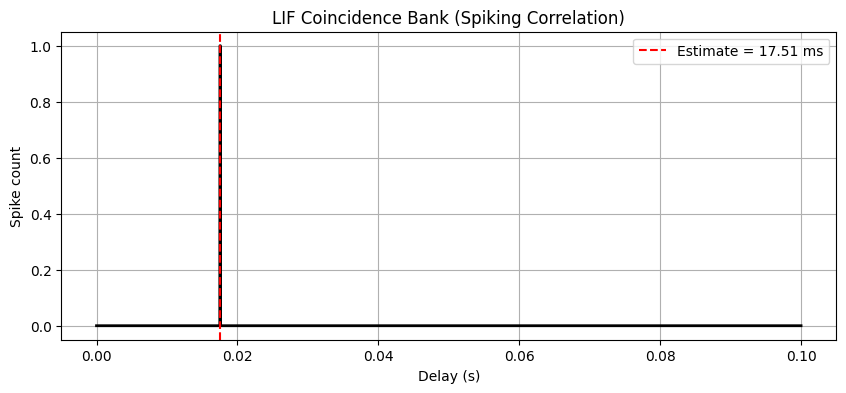

In [282]:
# Processing unit

result = processing_model.estimate(
    tx.spikes,
    rx.recovered_spikes,
)
print(result)

processing_model.plot(result)

distance_est = result.distance_m
delay_s = result.delay_s




In [283]:
# Output

results = SpikingRadarResult_1D(
    distance_m=distance_est,
    delay_s=delay_s,
    correlation=result.spike_counts,
    lag_s=result.delays_s,
    tx=tx,
    rx=rx,
    objects=objects
)

results.print_results()


--- RESULTS ---
Actual Wall Distance:    3.0 m
Calculated Distance:     3.002965 m
Error:                   0.0029650000000001064 m


-----